In [15]:
# we want to be able to import zvar_utils from the parent directory
import glob
import sys
sys.path.append("..")

import fpw # (needs to be installed from a .whl generated by Sam)
import numpy as np
import pandas as pd
from astropy.timeseries import LombScargle

from zvar_utils.candidate import VariabilityCandidate
from zvar_utils.kowalski import connect_to_kowalski, get_ipac_dr_lightcurves
from zvar_utils.photometry import freq_grid
from zvar_utils.plot import plot_hr_diagram, plot_lightcurve, plot_periodicity
from zvar_utils.enums import FILTERS, FILTER2IDX
from zvar_utils.files import retrieve_objs_lightcurve, get_ssh_client

In [16]:
k = connect_to_kowalski("../credentials.json", verbose=False)

In [17]:
band = 'r'
cand_files = glob.glob(f'../data/variability_candidates/0279/*_z{band}.csv', recursive=True)
candidate_list = []
for file in cand_files:
    df = pd.read_csv(file)
    freqs = np.array([df['frequency_20'], df['frequency_10'], df['frequency_5']])
    faps = np.array([df['FAP_20'], df['FAP_10'], df['FAP_5']])
    for i in range(df.shape[0]):
        if df['best_M'][i] == 20:
            candidate_list.append(VariabilityCandidate(df['psid'][i], df['ra'][i], df['dec'][i], df['valid'][i], freqs[0, i], faps[0, i], df['best_M'][i],
                                                        df['G'][i], df['BP'][i], df['RP'][i], df['parallax'][i], gaia_MG=df['MG'][i], gaia_BP_RP=df['BP_RP'][i]))
        if df['best_M'][i] == 10:
            candidate_list.append(VariabilityCandidate(df['psid'][i], df['ra'][i], df['dec'][i], df['valid'][i], freqs[1, i], faps[1, i], df['best_M'][i],
                                                        df['G'][i], df['BP'][i], df['RP'][i], df['parallax'][i], gaia_MG=df['MG'][i], gaia_BP_RP=df['BP_RP'][i]))
        if df['best_M'][i] == 5:
            candidate_list.append(VariabilityCandidate(df['psid'][i], df['ra'][i], df['dec'][i], df['valid'][i], freqs[2, i], faps[2, i], df['best_M'][i],
                                                        df['G'][i], df['BP'][i], df['RP'][i], df['parallax'][i], gaia_MG=df['MG'][i], gaia_BP_RP=df['BP_RP'][i]))
            
print(f"Loaded {len(candidate_list)} candidates, from {len(cand_files)} files")

Loaded 13815 candidates, from 1 files


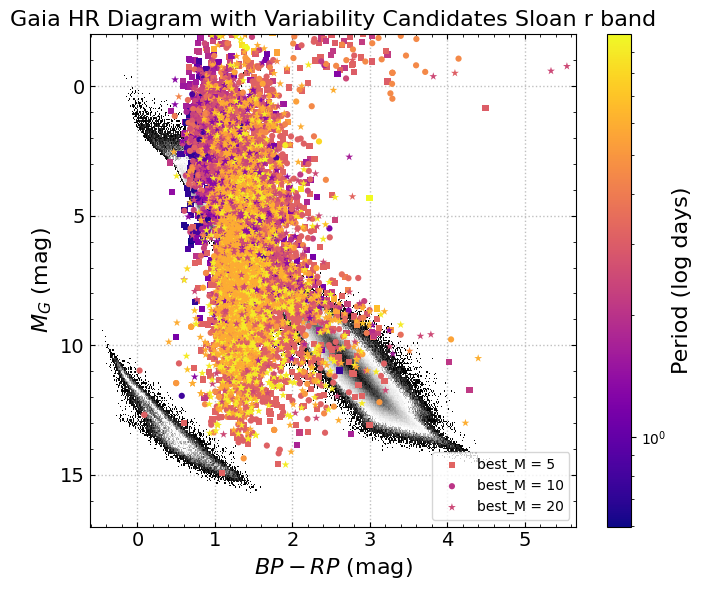

In [25]:
plot_hr_diagram(candidate_list, band, show_plot=True, figsize=(7,6))

In [19]:
red_candidates = []
for candidate in candidate_list:
    if (candidate.gaia_BP_RP is not None) and (candidate.gaia_BP_RP > 3):
        red_candidates.append(candidate)
red_candidates = sorted(red_candidates, key=lambda x: x.fap)
print(f"Found {len(red_candidates)} red candidates")

wd_candidates = []
for candidate in candidate_list:
    if (candidate.gaia_BP_RP is not None) and (candidate.gaia_BP_RP < 2) and (candidate.gaia_MG is not None) and (candidate.gaia_MG > 10):
        wd_candidates.append(candidate)
wd_candidates = sorted(wd_candidates, key=lambda x: x.fap)
print(f"Found {len(wd_candidates)} white dwarf candidates")

giant_candidates = []
for candidate in candidate_list:
    if (candidate.gaia_BP_RP is not None) and (candidate.gaia_BP_RP > 1) and (candidate.gaia_MG is not None) and (candidate.gaia_MG < 3):
        giant_candidates.append(candidate)
giant_candidates = sorted(giant_candidates, key=lambda x: x.fap)
print(f"Found {len(giant_candidates)} giant candidates")

#Short period candidates are anything with a period less than 1 hour
short_candidates = []
for candidate in candidate_list:
    if 1/candidate.freq < 1/24:
        short_candidates.append(candidate)
short_candidates = sorted(short_candidates, key=lambda x: x.fap)
print(f"Found {len(short_candidates)} short period candidates")


Found 70 red candidates
Found 709 white dwarf candidates
Found 1100 giant candidates
Found 1 short period candidates


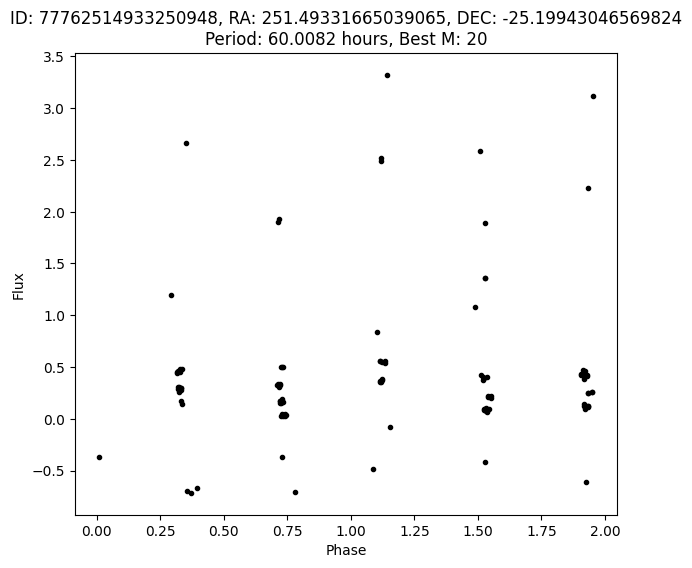

In [26]:
candidates = red_candidates
for candidate in candidates:
    result = get_ipac_dr_lightcurves(k, candidate.ra, candidate.dec, 50)
    if result is not None:
        barycorr_times, flux, ferrs = result
        plot_lightcurve(candidate, barycorr_times, flux, ferrs, show_plot=True, figsize=(7,6))
        break # comment out to print all lightcurves

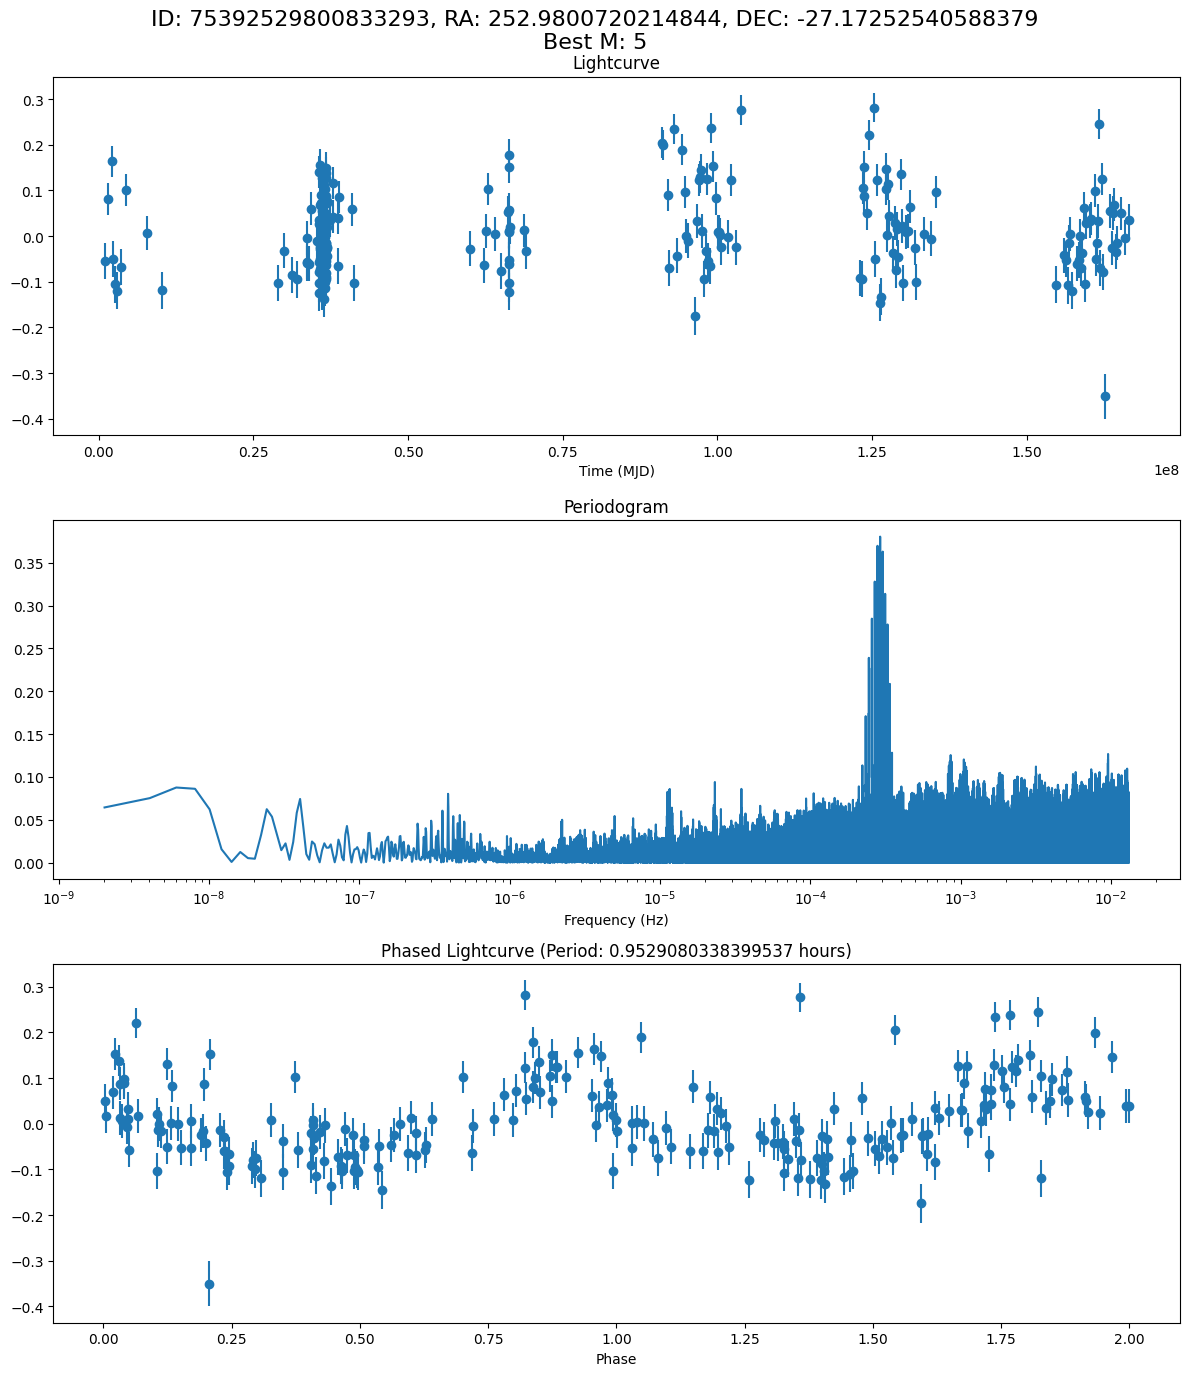

In [27]:
candidate = short_candidates[0]
ra, dec = candidate.ra, candidate.dec
min_epochs = 50

time, flux, fluxerr = get_ipac_dr_lightcurves(k, ra, dec, min_epochs)

fgrid = freq_grid(time)

ls_pgram = LombScargle(time, flux, fluxerr).power(fgrid)
best_period = 1/fgrid[np.argmax(ls_pgram)]

plot_periodicity(candidate, time, flux, fluxerr, ls_pgram, best_period, show_plot=True)

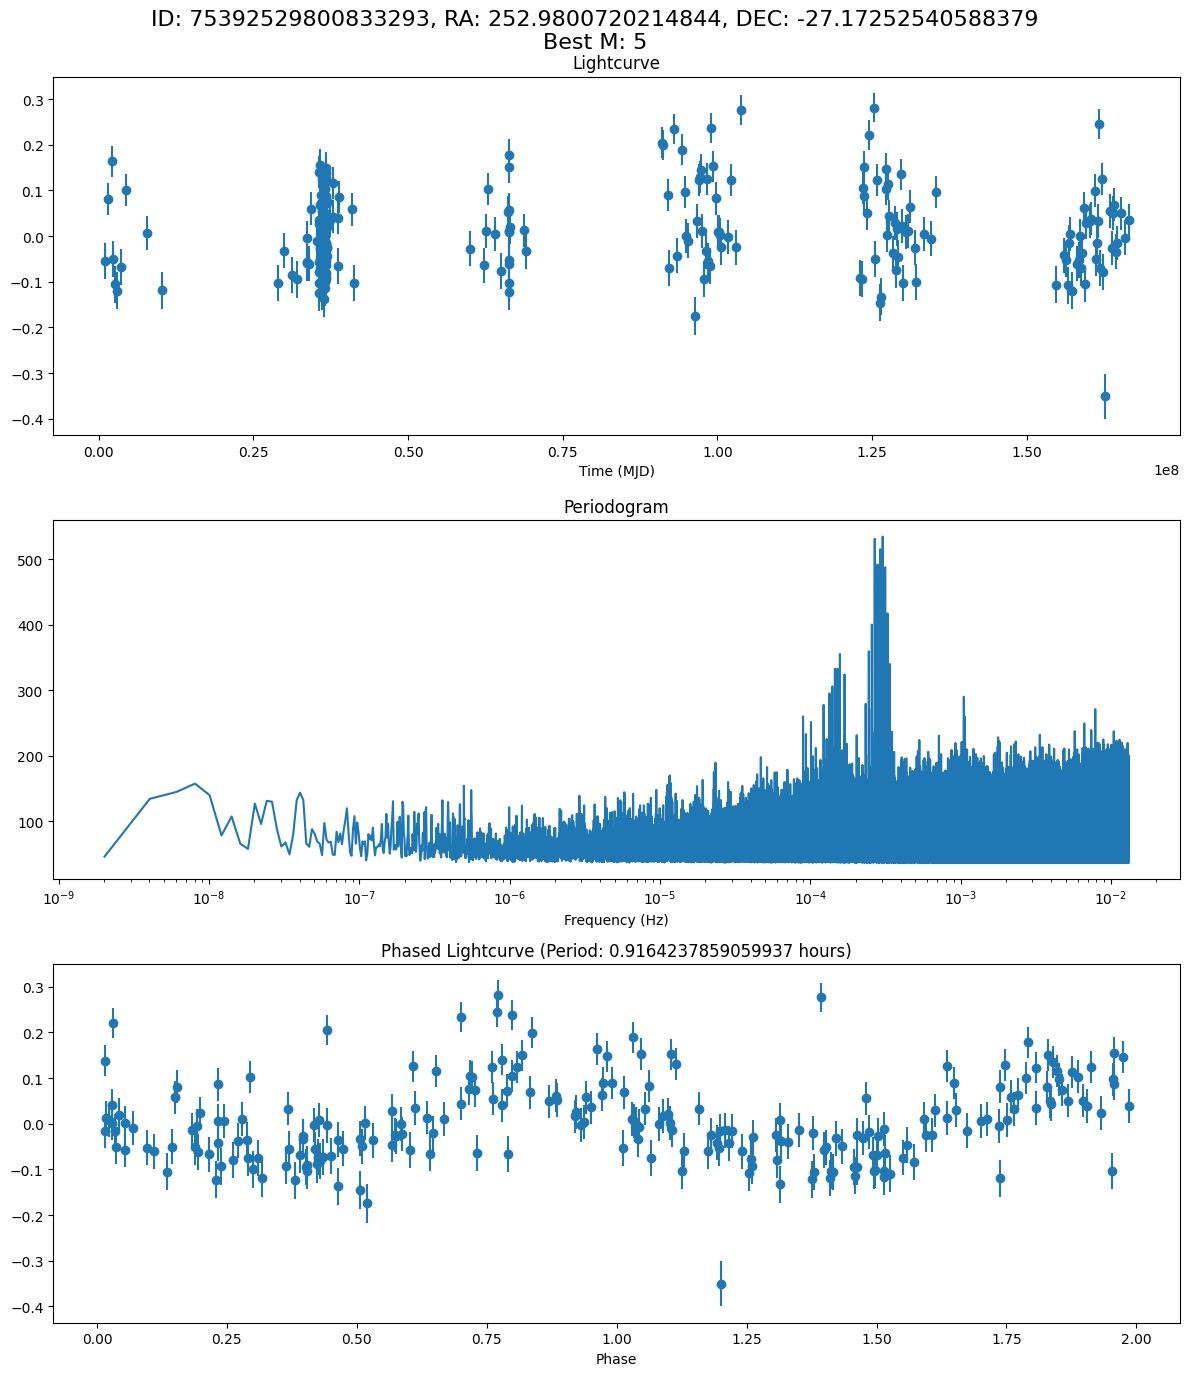

In [22]:
# Same but with Sam's FPW (needs to be installed from .whl)

f_grid = freq_grid(time)
fpw_pgram = fpw.run_fpw(time, flux, fluxerr, fgrid, 5)
fpw_pgram[np.isnan(fpw_pgram)] = 0
best_period = 1/fgrid[np.argmax(fpw_pgram)]

plot_periodicity(candidate, time, flux, fluxerr, fpw_pgram, best_period, show_plot=True)

In [23]:
############# EXAMPLE: multiple objects #############

# first we initialize some variables
# we need to find the files locally and remotely
path_lc = '../data/zvar/lc'
remote_path_lc = '/data/zvar/matchfiles'

host = 'magnetar.caltech.edu'

# if you want to use an ssh client to connect to the remote host,
# you can optionally provide a username and password
# if you do not a password, you have to provide the path
# to your private key instead
username = 'tdulaz'
# password = '<your_password>'
pkey_path = '<your_private_key_path>'

# ssh_client = get_ssh_client(host, username, password)
ssh_client = get_ssh_client(host, username=username, pkey_path=pkey_path)

# we will retrieve the lightcurves for these objects
psid1, ra1, dec1 = red_candidates[0].id, red_candidates[0].ra, red_candidates[0].dec
psid2, ra2, dec2 = red_candidates[1].id, red_candidates[1].ra, red_candidates[1].dec
psid3, ra3, dec3 = red_candidates[2].id, red_candidates[2].ra, red_candidates[2].dec

objects = [(psid1, ra1, dec1), (psid2, ra2, dec2), (psid3, ra3, dec3)]

# this will download all the files first, and then read the lightcurves for each object
photometry_per_obj = retrieve_objs_lightcurve(objects, path_lc, ssh_client, remote_path_lc)

for psid, photometry in photometry_per_obj.items():
    print(f'\nFound {len(photometry)} photometry points for {psid}')
    # print how many we have per filter
    for filter in FILTERS:
        n = len([p for p in photometry if p[2] == FILTER2IDX[filter]])
        print(f'{filter}: {n}')

# CAUTION: don't forget to close the ssh client at the end of your script!
if ssh_client:
    ssh_client.close()


Found 475 photometry points for 76792491231539360
g: 81
r: 394

Found 477 photometry points for 77762514933250948
g: 81
r: 396

Found 462 photometry points for 77742511448491703
g: 72
r: 390


In [24]:
# Using an ssh client to connect to magnetar and retrieve the lightcurves
# is optional, you can also ignore the ssh_client argument in retrieve_objs_lightcurve
# and the function will just look for the files locally

photometry_per_obj = retrieve_objs_lightcurve(objects, path_lc)

for psid, photometry in photometry_per_obj.items():
    print(f'\nFound {len(photometry)} photometry points for {psid}')
    # print how many we have per filter
    for filter in FILTERS:
        n = len([p for p in photometry if p[2] == FILTER2IDX[filter]])
        print(f'{filter}: {n}')


Found 475 photometry points for 76792491231539360
g: 81
r: 394

Found 477 photometry points for 77762514933250948
g: 81
r: 396

Found 462 photometry points for 77742511448491703
g: 72
r: 390
